In [1]:
# !cd data/ && pdftohtml -c -hidden -xml gdd.pdf gdd.pdf

In [2]:
# !ls -1 data/

In [3]:
# !head -n 30 data/gdd.pdf.xml

In [4]:
DATAPATH = 'data/'
OUTPUTPATH = 'generated_output/'
# INPUT_XML = 'gdd.pdf.xml'
INPUT_IMG = '尺寸012Gerber 文件.jpg'

In [5]:
# import os
# from pdftabextract.common import read_xml, parse_pages

# # Load the XML that was generated with pdftohtml
# xmltree, xmlroot = read_xml(os.path.join(DATAPATH, INPUT_XML))

# # parse it and generate a dict of pages
# pages = parse_pages(xmlroot)

In [6]:
# pages

In [7]:
# xmltree, xmlroot

In [8]:
# from pprint import pprint

# p_num = 1
# p = pages[p_num]

# print('number', p['number'])
# print('width', p['width'])
# print('height', p['height'])
# print('image', p['image'])
# print('the first three text boxes:')
# pprint(p['texts'][:3])

In [9]:
import os
input_img_path = os.path.join(DATAPATH, INPUT_IMG)

In [10]:
import cv2
image = cv2.imread(input_img_path)
width,height,_ = image.shape
width,height

(2543, 1462)

In [11]:
import numpy as np
from pdftabextract import imgproc

# get the image file of the scanned page
# imgfilebasename = p['image'][:p['image'].rindex('.')]
imgfile = os.path.join(DATAPATH, INPUT_IMG)

# print("page %d: detecting lines in image file '%s'..." % (p_num, imgfile))

# create an image processing object with the scanned page
iproc_obj = imgproc.ImageProc(imgfile)


In [12]:
# calculate the scaling of the image file in relation to the text boxes coordinate system dimensions
page_scaling_x = iproc_obj.img_w / width   # scaling in X-direction
page_scaling_y = iproc_obj.img_h / height # scaling in Y-direction

# detect the lines
lines_hough = iproc_obj.detect_lines(canny_kernel_size=3, canny_low_thresh=50, canny_high_thresh=150,
                                     hough_rho_res=1,
                                     hough_theta_res=np.pi/500,
                                     hough_votes_thresh=round(0.2 * iproc_obj.img_w))
print("> found %d lines" % len(lines_hough))

> found 80 lines


In [13]:
lines_hough

[(1042.0, 0.0, 0.0, 'v'),
 (84.0, 0.0, 0.0, 'v'),
 (1038.0, 0.0, 0.0, 'v'),
 (88.0, 0.0, 0.0, 'v'),
 (987.0, 0.0, 0.0, 'v'),
 (1150.0, 0.0, 0.0, 'v'),
 (1154.0, 0.0, 0.0, 'v'),
 (137.0, 0.0, 0.0, 'v'),
 (984.0, 0.0, 0.0, 'v'),
 (144.0, 0.0, 0.0, 'v'),
 (565.0, 0.0, 0.0, 'v'),
 (561.0, 0.0, 0.0, 'v'),
 (2470.0, 1.5707964, 1.5707964, 'h'),
 (576.0, 1.5707964, 1.5707964, 'h'),
 (580.0, 1.5707964, 1.5707964, 'h'),
 (690.0, 1.5707964, 1.5707964, 'h'),
 (687.0, 1.5707964, 1.5707964, 'h'),
 (2037.0, 1.5707964, 1.5707964, 'h'),
 (1120.0, 1.5707964, 1.5707964, 'h'),
 (2020.0, 1.5707964, 1.5707964, 'h'),
 (2040.0, 1.5707964, 1.5707964, 'h'),
 (1137.0, 1.5707964, 1.5707964, 'h'),
 (2016.0, 1.5707964, 1.5707964, 'h'),
 (1140.0, 1.5707964, 1.5707964, 'h'),
 (1115.0, 1.5707964, 1.5707964, 'h'),
 (2465.0, 1.5707964, 1.5707964, 'h'),
 (1566.0, 1.5707964, 1.5707964, 'h'),
 (1570.0, 1.5707964, 1.5707964, 'h'),
 (1590.0, 1.5707964, 1.5707964, 'h'),
 (124.0, 1.5707964, 1.5707964, 'h'),
 (648.0, 0.0, 0.0, 

In [14]:
import cv2

# helper function to save an image 
def save_image_w_lines(iproc_obj, imgfilebasename):
    img_lines = iproc_obj.draw_lines(orig_img_as_background=True)
    img_lines_file = os.path.join(OUTPUTPATH, '%s-lines-orig.png' % imgfilebasename)
    
    print("> saving image with detected lines to '%s'" % img_lines_file)
    cv2.imwrite(img_lines_file, img_lines)

In [15]:
save_image_w_lines(iproc_obj, INPUT_IMG)

> saving image with detected lines to 'generated_output/尺寸012Gerber 文件.jpg-lines-orig.png'


In [16]:
from pdftabextract.clustering import find_clusters_1d_break_dist

MIN_COL_WIDTH = 30 # minimum width of a column in pixels, measured in the scanned pages

# cluster the detected *vertical* lines using find_clusters_1d_break_dist as simple clustering function
# (break on distance MIN_COL_WIDTH/2)
# additionally, remove all cluster sections that are considered empty
# a cluster is considered empty when the number of text boxes in it is below 10% of the median number of text boxes
# per cluster section

vertical_clusters = iproc_obj.find_clusters(imgproc.DIRECTION_VERTICAL, find_clusters_1d_break_dist,
#                                             remove_empty_cluster_sections_use_texts=p['texts'], # use this page's textboxes
#                                             remove_empty_cluster_sections_n_texts_ratio=0.1,    # 10% rule
#                                             remove_empty_cluster_sections_scaling=page_scaling_x,  # the positions are in "scanned image space" -> we scale them to "text box space"
                                            dist_thresh=MIN_COL_WIDTH/2)
print("> found %d vertical clusters" % len(vertical_clusters))
img_v_clusters = iproc_obj.draw_line_clusters(imgproc.DIRECTION_VERTICAL, vertical_clusters)
save_img_v_file = os.path.join(OUTPUTPATH, '%s-vertical-clusters.png' % INPUT_IMG)
cv2.imwrite(save_img_v_file, img_v_clusters)


horizontal_clusters = iproc_obj.find_clusters(imgproc.DIRECTION_HORIZONTAL, find_clusters_1d_break_dist,
#                                             remove_empty_cluster_sections_use_texts=p['texts'], # use this page's textboxes
#                                             remove_empty_cluster_sections_n_texts_ratio=0.1,    # 10% rule
#                                             remove_empty_cluster_sections_scaling=page_scaling_x,  # the positions are in "scanned image space" -> we scale them to "text box space"
                                            dist_thresh=MIN_COL_WIDTH/2)
print("> found %d horizontal clusters" % len(horizontal_clusters))
img_h_clusters = iproc_obj.draw_line_clusters(imgproc.DIRECTION_HORIZONTAL, horizontal_clusters)
save_img_h_file = os.path.join(OUTPUTPATH, '%s-horizontal-clusters.png' % INPUT_IMG)
cv2.imwrite(save_img_h_file, img_h_clusters)


> found 8 vertical clusters
> found 11 horizontal clusters


True

In [17]:
from pdftabextract.clustering import calc_cluster_centers_1d

vertical = np.array(calc_cluster_centers_1d(vertical_clusters)) #/ page_scaling_x
horizontal = np.array(calc_cluster_centers_1d(horizontal_clusters)) #/ page_scaling_y
print('found %d column borders:' % len(vertical))
print(vertical)
print('found %d raw borders:' % len(horizontal))
print(horizontal)

found 8 column borders:
[  84.  143.  227.  563.  650.  984. 1042. 1152.]
found 11 raw borders:
[ 126.00005558  157.00005558  195.00005558  222.00005558  578.00005558
  688.50005558 1135.51676016 1568.00005558 1588.00005558 2035.52562435
 2467.50005558]


In [18]:
for v in vertical:
    cv2.line(image,(int(v),1),(int(v),width),(0,0,255),1)
for h in horizontal:
    cv2.line(image,(1,int(h)),(height,int(h)),(0,255,0),1)

save_img_file = os.path.join(OUTPUTPATH, '%s_lines.png' % INPUT_IMG)
cv2.imwrite(save_img_file, image)

True

提取文字如下：

In [19]:
from PIL import Image
import pytesseract
import argparse
import cv2
import os
 
# construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,help="path to input image to be OCR'd")
# ap.add_argument("-p", "--preprocess", type=str, default="thresh",help="type of preprocessing to be done")
# args = vars(ap.parse_args())

In [20]:
# load the example image and convert it to grayscale
# image = cv2.imread(input_img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
# # check to see if we should apply thresholding to preprocess the
# # image
# if args["preprocess"] == "thresh":
#     gray = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
# # make a check to see if median blurring should be done to remove
# # noise
# elif args["preprocess"] == "blur":
#     gray = cv2.medianBlur(gray, 3)
 
# write the grayscale image to disk as a temporary file so we can
# apply OCR to it

# cv2.imwrite(os.path.join(input_img_path +'_gray.png'), gray)

In [21]:
# load the image as a PIL/Pillow image, apply OCR, and then delete
# the temporary file

text = pytesseract.image_to_string(gray)
text



"36 to 45\n\nI/I/I/I/I/IlE'I/II/Illlll'll\n\nAZﬂﬁZZZﬂZZQZZQZZQZZQZI\nIIIIIIIIIIIA'A llA’I/Illlll/I\n\nV-cuf Detail\n\n \n\n \n \n   \n\n \n\n-ﬁ.\n\n \n\n \n\n \n\n \n\n \n\n   \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n167.?"

提取示意图如下：

In [22]:
image = cv2.imread(input_img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [23]:
gray.shape

(2543, 1462)

In [24]:
# cv2.imshow('image',image)
from matplotlib import pyplot as plt
plt.imshow(gray)

In [25]:
im = gray/225

In [26]:
datas = []
lables = []
for i in range(width):
    for j in range(height):
        label = im[i][j]
        if label > 0.5:
            datas.append([j,i])
            lables.append(1)

In [27]:
len(datas)

55333

In [28]:
from sklearn.cluster import MiniBatchKMeans, KMeans, SpectralClustering

In [29]:
# spectral_cluster = SpectralClustering(n_clusters=2,
#                                                       assign_labels="discretize",
#                                                       random_state=0)
# pred = spectral_cluster.fit_predict(datas)

In [30]:
k_means = KMeans(init='k-means++', n_clusters=2, n_init=10)
pred = k_means.fit_predict(datas)

In [31]:
x_data = []
y_data = []
color = []
choose_colors = ['#4EACC5', '#FF9C34','#EEFFBB','#DDFF77','#CCFF33','#668800']
for i in range(len(pred)):
#     pred[i]
    x,y = datas[i]
    x_data.append(x)
    y_data.append(y)
    color.append(choose_colors[pred[i]])

<function matplotlib.pyplot.show(*args, **kw)>

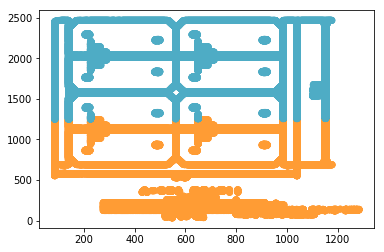

In [32]:
plt.scatter(x_data, y_data, color = color)
plt.show

In [33]:
#使用扩展像素+联通判断！

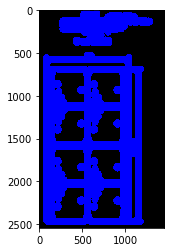

In [34]:
#方案1 画圈圈
extend_size = 40

img_out = np.zeros(image.shape, np.uint8) # Create a black image
for data in datas:
    img_out = cv2.circle(img_out, tuple(data), extend_size, (0,0,255), -1)
    
plt.imshow(img_out)

In [39]:
img_out.shape

(2543, 1462, 3)

In [40]:

img_out = cv2.threshold(img_out, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
ret, labels = cv2.connectedComponents(img_out)



error: OpenCV(3.4.3) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/connectedcomponents.cpp:3927: error: (-215:Assertion failed) L.channels() == 1 && I.channels() == 1 in function 'connectedComponents_sub1'


In [ ]:
# Map component labels to hue val
label_hue = np.uint8(179*labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# cvt to BGR for display
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

# set bg label to black
labeled_img[label_hue==0] = 0

cv2.imshow('labeled.png', labeled_img)
cv2.waitKey()

In [ ]:
#方案2 扩展
# extend_size = 3
# for data in datas:
#     x,y = data
#     for i in range(extend_size):
#         datas.append([x + i, y + i])
    
# datas_duplicate = np.array(datas)   
# datas = np.unique(datas_duplicate, axis=0)
# len(datas)

In [ ]:
# 方案3 color select in mask
# lower = np.array([100])
# upper = np.array([225])
# shapeMask = cv2.inRange(gray, lower, upper)

# # cv2.imshow("obj shapeMask", shapeMask)
# shapeMask_file = os.path.join(OUTPUTPATH, '%s_mask.png' % INPUT_IMG)
# plt.imshow(shapeMask)
# cv2.imwrite(shapeMask_file, shapeMask)